# Assignment 3

Mathia Quimpo, Matthew Chin, Wanqiu Zhang

## Exploration and Preprocessing

In [56]:
import pandas as pd
import numpy as np
import re
import os
import requests
import string
import nltk
import time
import matplotlib.pyplot as plt
import pyLDAvis
import seaborn as sns
import pyLDAvis.gensim_models as gensimvis
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation

In [7]:
# Load dataset
file_path = os.path.expanduser("~/Desktop/School/6200/Project/DisneylandReviews.csv")
df = pd.read_csv(file_path, encoding="ISO-8859-1")

print(df.head())

   Review_ID  Rating Year_Month     Reviewer_Location  \
0  670772142       4     2019-4             Australia   
1  670682799       4     2019-5           Philippines   
2  670623270       4     2019-4  United Arab Emirates   
3  670607911       4     2019-4             Australia   
4  670607296       4     2019-4        United Kingdom   

                                         Review_Text               Branch  
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1  Its been a while since d last time we visit HK...  Disneyland_HongKong  
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong  
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong  
4  the location is not in the city, took around 1...  Disneyland_HongKong  


In [8]:
# Display column names
print("Columns in the dataset:\n", df.columns)

Columns in the dataset:
 Index(['Review_ID', 'Rating', 'Year_Month', 'Reviewer_Location', 'Review_Text',
       'Branch'],
      dtype='object')


In [82]:
# Checking the unique values in the 'branch' column (if available)
print(df['Branch'].unique())

['Disneyland_HongKong' 'Disneyland_California' 'Disneyland_Paris']


In [9]:
# Get general info
print(df.info())

# Descriptive statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB
None
          Review_ID        Rating
count  4.265600e+04  42656.000000
mean   3.188553e+08      4.217695
std    1.657092e+08      1.063371
min    1.398724e+06      1.000000
25%    1.743274e+08      4.000000
50%    2.907583e+08      5.000000
75%    4.489579e+08      5.000000
max    6.708014e+08      5.000000
Review_ID            0
Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
Branch               0
dtype: int64


In [10]:
# Display the entire review text
pd.set_option('display.max_colwidth', None)

In [15]:
# Identify the main text column
text_column = "Review_Text"

# Basic statistics on text length
df["text_length"] = df[text_column].astype(str).apply(len)

print("\nText Length Statistics:")
print(df["text_length"].describe())

# Spot-check a few reviews
print("\nSample Reviews:\n", df[text_column].sample(7, random_state=40))


Text Length Statistics:
count    42656.000000
mean       696.817540
std        831.396751
min         18.000000
25%        239.000000
50%        435.000000
75%        837.000000
max      20756.000000
Name: text_length, dtype: float64

Sample Reviews:
 4018                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         We spent 2 days with our girls, 9 and 6, and had a fantastic time. Ideal for kids of our age who could go on most rides. Sometimes height can be an issue at theme parks but not in Hong Kong!Sunday and Monday were good days to visit, with 

In [13]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [103]:
# Filter reviews for each branch
df_cali = df[df['Branch'] == 'Disneyland_California']
df_hk = df[df['Branch'] == 'Disneyland_HongKong']
df_paris = df[df['Branch'] == 'Disneyland_Paris']

In [104]:
# Check how many rows are in each branch after filtering
print(f"California reviews: {df_cali.shape[0]}")
print(f"Hong Kong reviews: {df_hk.shape[0]}")
print(f"Paris reviews: {df_paris.shape[0]}")

California reviews: 19406
Hong Kong reviews: 9620
Paris reviews: 13630


In [105]:
# Define text cleaning function
def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    words = word_tokenize(text)  # Tokenize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatization and stopword removal
    return " ".join(words)

In [106]:
# Clean text function applied separately to each branch
def preprocess_for_branch(df_branch):
    df_branch["cleaned_text"] = df_branch[text_column].apply(clean_text)
    return df_branch

# Apply preprocessing to each branch
df_cali = preprocess_for_branch(df_cali)
df_hk = preprocess_for_branch(df_hk)
df_paris = preprocess_for_branch(df_paris)

/var/folders/s9/391mgjzx02v3g4pq8lv43vm00000gp/T/ipykernel_55266/209908346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_branch["cleaned_text"] = df_branch[text_column].apply(clean_text)
/var/folders/s9/391mgjzx02v3g4pq8lv43vm00000gp/T/ipykernel_55266/209908346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_branch["cleaned_text"] = df_branch[text_column].apply(clean_text)
/var/folders/s9/391mgjzx02v3g4pq8lv43vm00000gp/T/ipykernel_55266/209908346.py:3: SettingWithCopyWarning: 
A value is try

In [107]:
# Spot-check cleaned reviews
print("\nSample Cleaned Reviews:\n", df["cleaned_text"].sample(5, random_state=42))


Sample Cleaned Reviews:
 31092                                                                                                                                                                                                    disneyland beautiful largeto see need stay least daysas lot people large quits worth good organized best holiday experience
28105    line ride long yes fast pass help little standing line hour get min ride ridiculous rd trip feel like keep getting worse longer there people le space ride go could day ive gone think ill sticking park arent busy im sure however youre young impressionable child love notice im past age stomach kind work reward ratio
1121                                                                                                                                                                                                          loved hong kong disneyland although much smaller anaheim one big queue happy atmosphere beautiful clean organised park

## CountVectorizer

In [108]:
# Use CountVectorizer for Bag of Words model on each branch
count_vectorizer = CountVectorizer(max_features=10000, stop_words='english')

# For each branch, create the Bag of Words matrix
X_bow_cali = count_vectorizer.fit_transform(df_cali["cleaned_text"])
X_bow_hk = count_vectorizer.fit_transform(df_hk["cleaned_text"])
X_bow_paris = count_vectorizer.fit_transform(df_paris["cleaned_text"])

# Get feature names for each branch
feature_names_cali = count_vectorizer.get_feature_names_out()
feature_names_hk = count_vectorizer.get_feature_names_out()
feature_names_paris = count_vectorizer.get_feature_names_out()

# Display shape of the BoW matrix for each branch
print(f"\nBag of Words Matrix Shape (California): {X_bow_cali.shape}")
print(f"Bag of Words Matrix Shape (Hong Kong): {X_bow_hk.shape}")
print(f"Bag of Words Matrix Shape (Paris): {X_bow_paris.shape}")


Bag of Words Matrix Shape (California): (19406, 10000)
Bag of Words Matrix Shape (Hong Kong): (9620, 10000)
Bag of Words Matrix Shape (Paris): (13630, 10000)


In [109]:
# Function to prepare corpus and dictionary
def prepare_corpus(df_branch):
    tokenized_texts = [text.split() for text in df_branch["cleaned_text"]]
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    return corpus, dictionary

# Prepare corpus and dictionary for each branch
corpus_cali, dictionary_cali = prepare_corpus(df_cali)
corpus_hk, dictionary_hk = prepare_corpus(df_hk)
corpus_paris, dictionary_paris = prepare_corpus(df_paris)

## LDA

In [112]:
# Train LDA Model
def train_lda(corpus, dictionary, num_topics=7):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                         random_state=42, passes=15, iterations=500, alpha='auto')
    return lda_model

# Train LDA for each branch
lda_model_cali = train_lda(corpus_cali, dictionary_cali, num_topics=7)
lda_model_hk = train_lda(corpus_hk, dictionary_hk, num_topics=7)
lda_model_paris = train_lda(corpus_paris, dictionary_paris, num_topics=7)

In [113]:
# Compute Coherence Score
def compute_coherence(lda_model, tokenized_texts, dictionary):
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Compute coherence for each branch
coherence_cali = compute_coherence(lda_model_cali, [text.split() for text in df_cali["cleaned_text"]], dictionary_cali)
coherence_hk = compute_coherence(lda_model_hk, [text.split() for text in df_hk["cleaned_text"]], dictionary_hk)
coherence_paris = compute_coherence(lda_model_paris, [text.split() for text in df_paris["cleaned_text"]], dictionary_paris)

print(f'Coherence Score (California): {coherence_cali:.4f}')
print(f'Coherence Score (Hong Kong): {coherence_hk:.4f}')
print(f'Coherence Score (Paris): {coherence_paris:.4f}')

Coherence Score (California): 0.4770
Coherence Score (Hong Kong): 0.4573
Coherence Score (Paris): 0.5168


In [114]:
# Compute Perplexity Score
perplexity_cali = lda_model_cali.log_perplexity(corpus_cali)
perplexity_hk = lda_model_hk.log_perplexity(corpus_hk)
perplexity_paris = lda_model_paris.log_perplexity(corpus_paris)

print(f'Perplexity Score (California): {np.exp(perplexity_cali):.4f}')
print(f'Perplexity Score (Hong Kong): {np.exp(perplexity_hk):.4f}')
print(f'Perplexity Score (Paris): {np.exp(perplexity_paris):.4f}')

Perplexity Score (California): 0.0007
Perplexity Score (Hong Kong): 0.0007
Perplexity Score (Paris): 0.0006


In [115]:
# Visualize for California
pyLDAvis.enable_notebook()
lda_vis_cali = gensimvis.prepare(lda_model_cali, corpus_cali, dictionary_cali)
pyLDAvis.display(lda_vis_cali)

In [116]:
# Visualize for Hong Kong
lda_vis_hk = gensimvis.prepare(lda_model_hk, corpus_hk, dictionary_hk)
pyLDAvis.display(lda_vis_hk)

In [117]:
# Visualize for Paris
lda_vis_paris = gensimvis.prepare(lda_model_paris, corpus_paris, dictionary_paris)
pyLDAvis.display(lda_vis_paris)

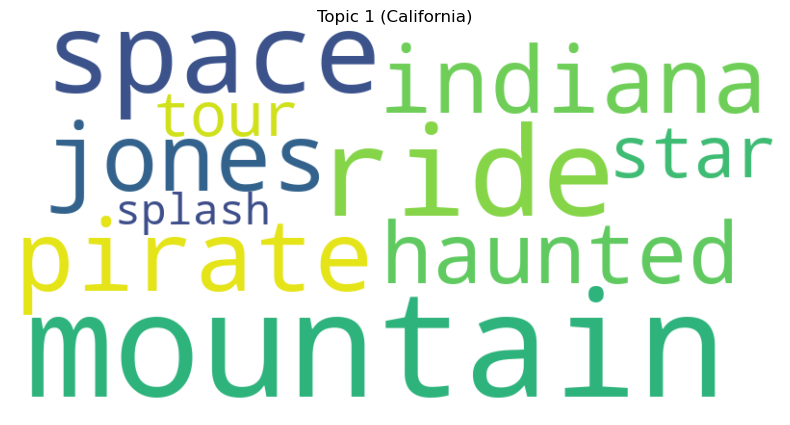

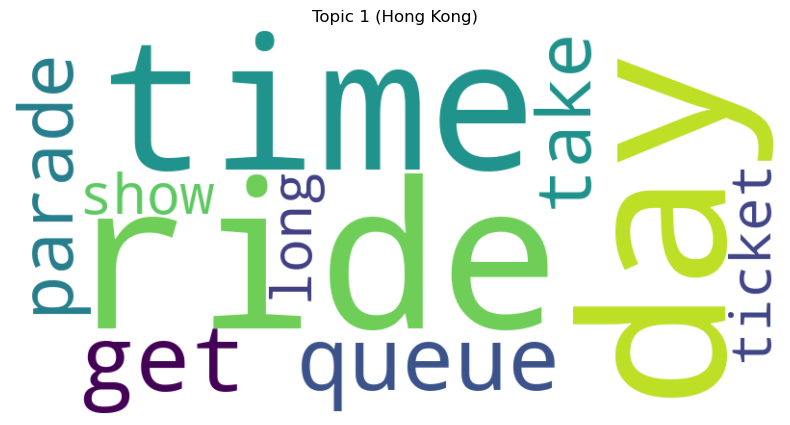

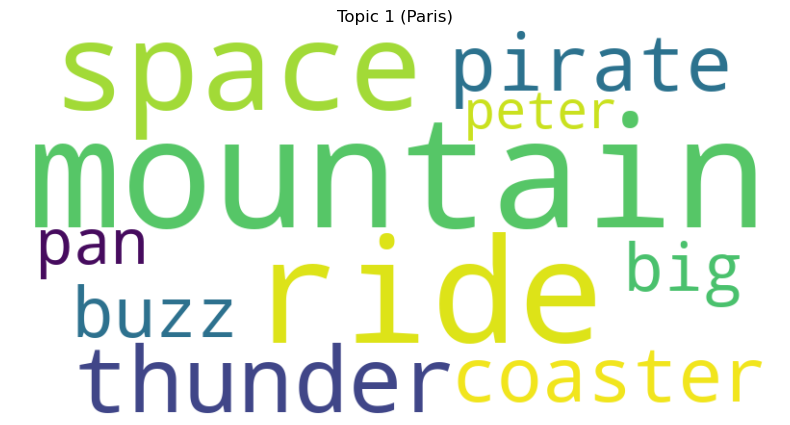

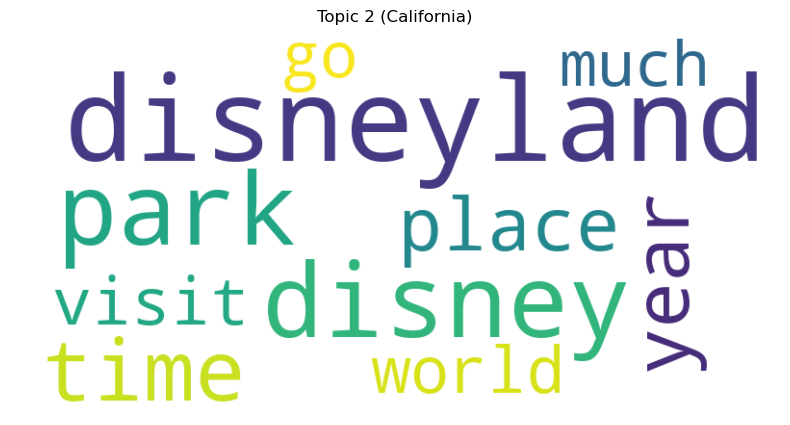

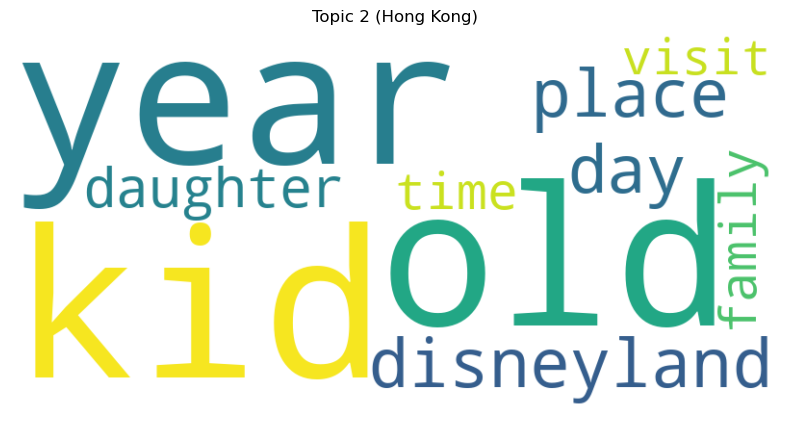

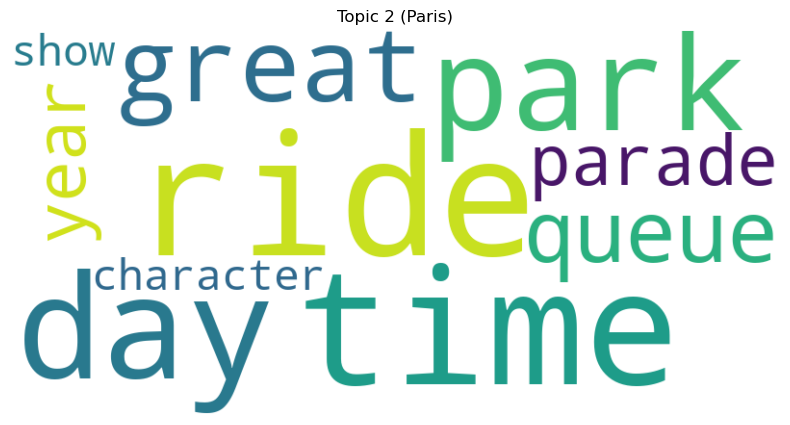

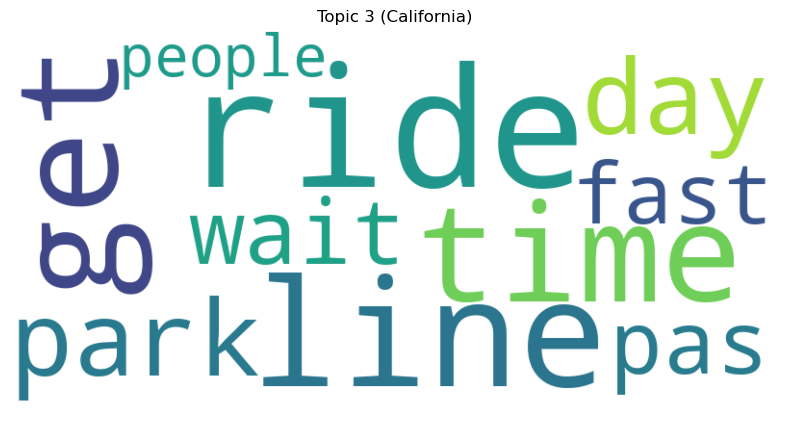

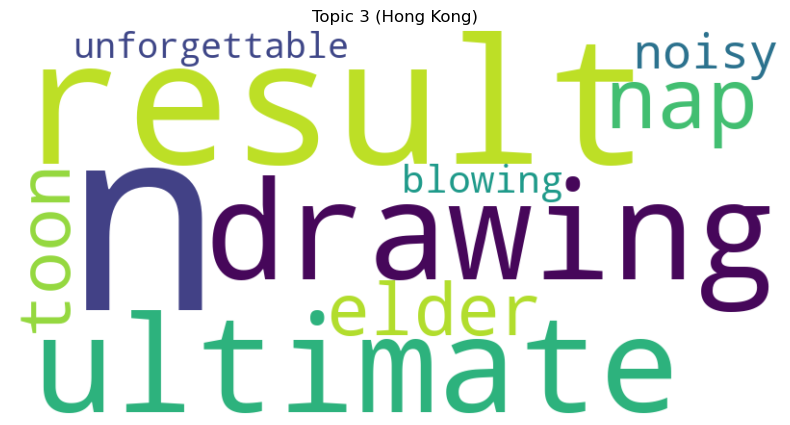

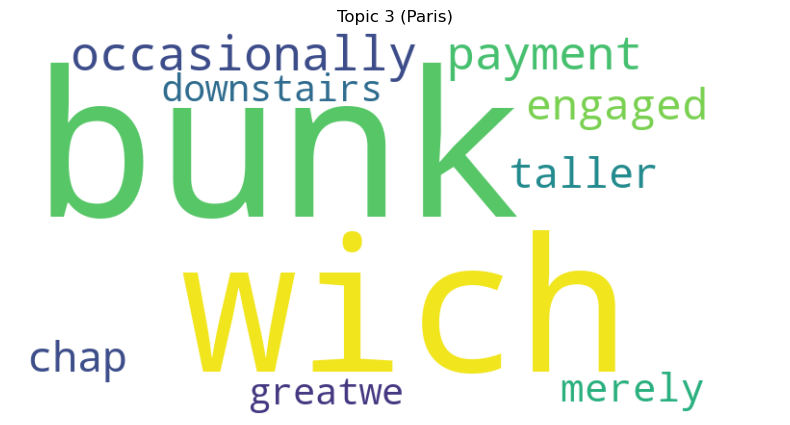

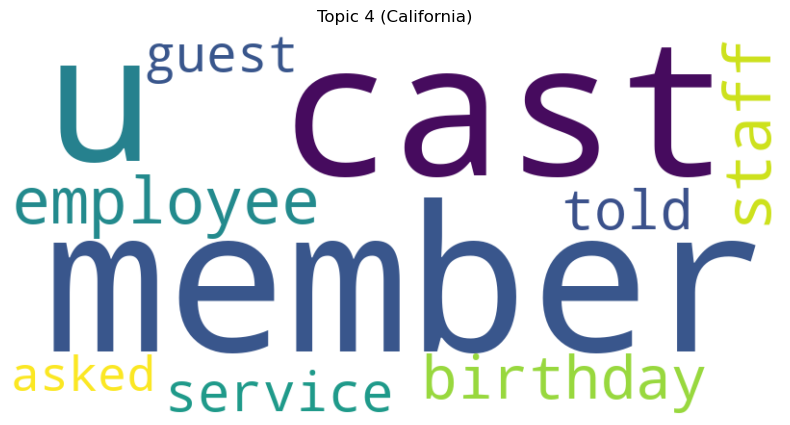

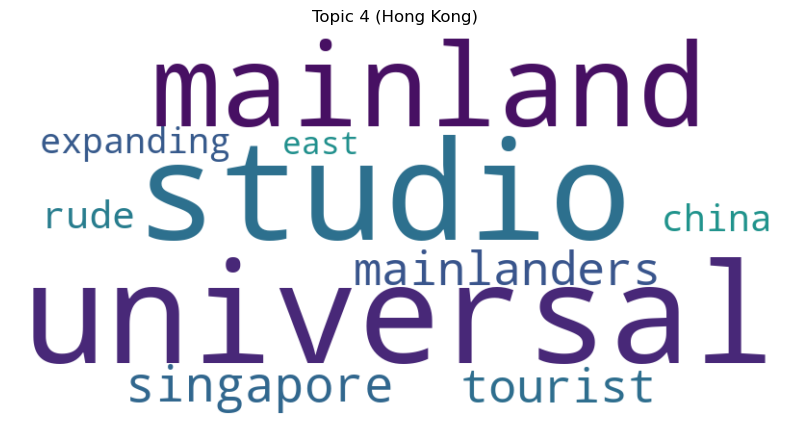

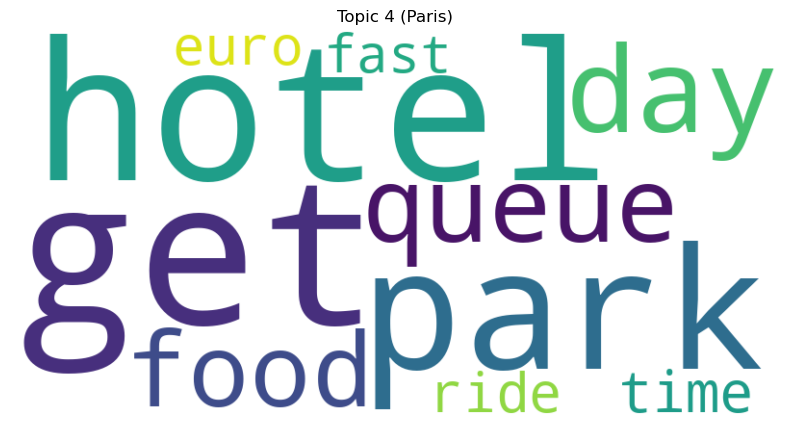

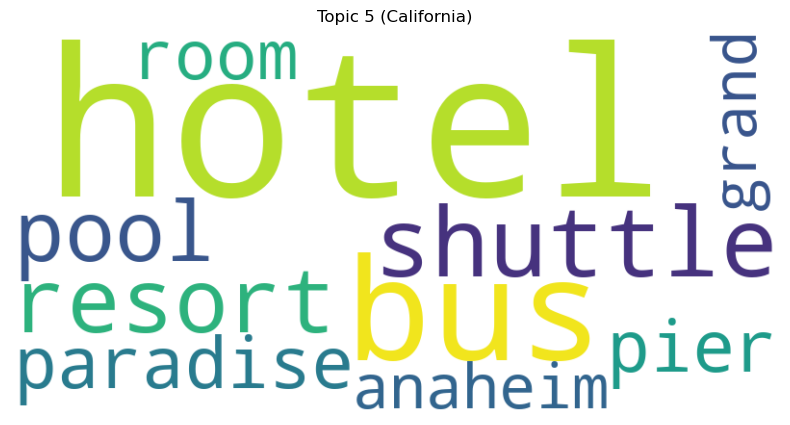

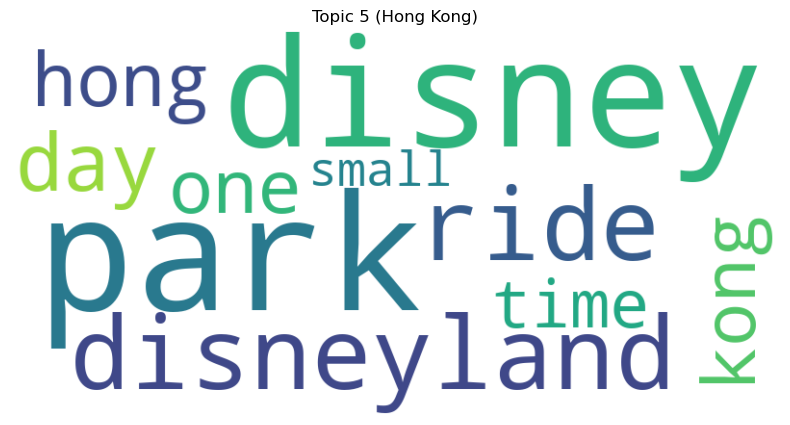

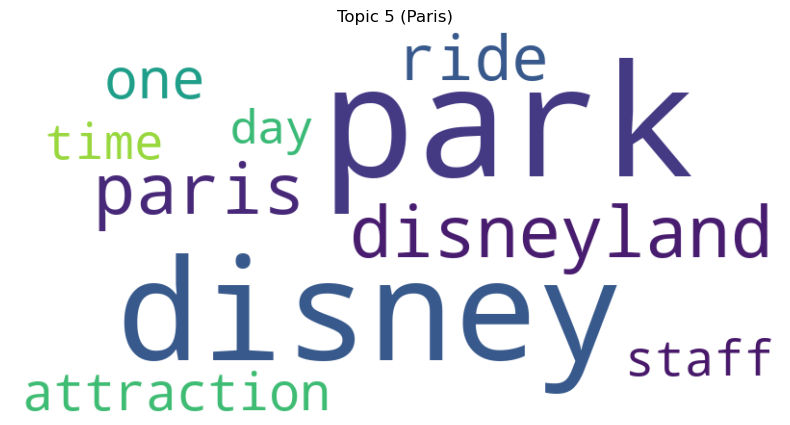

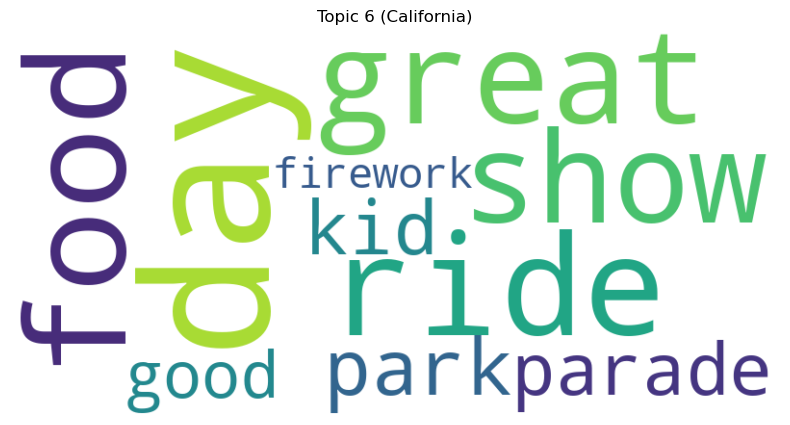

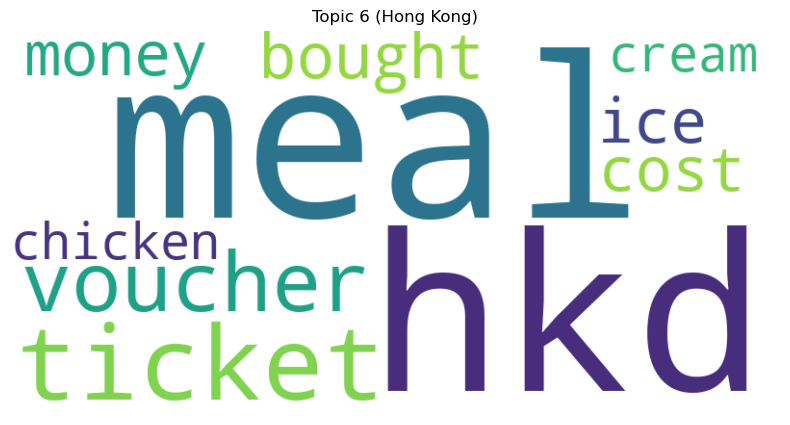

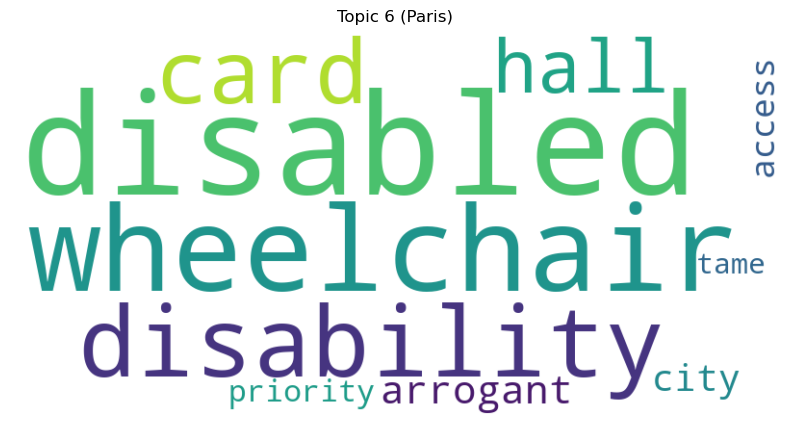

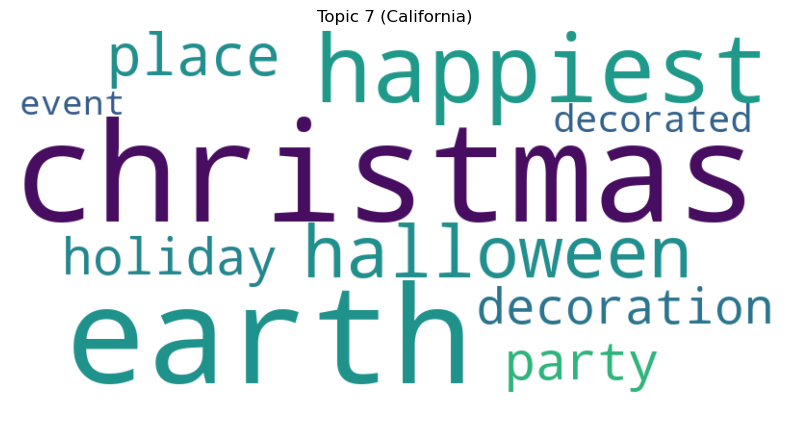

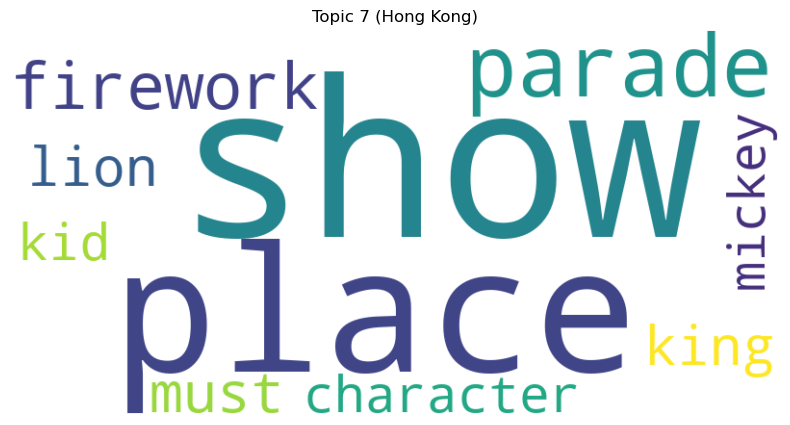

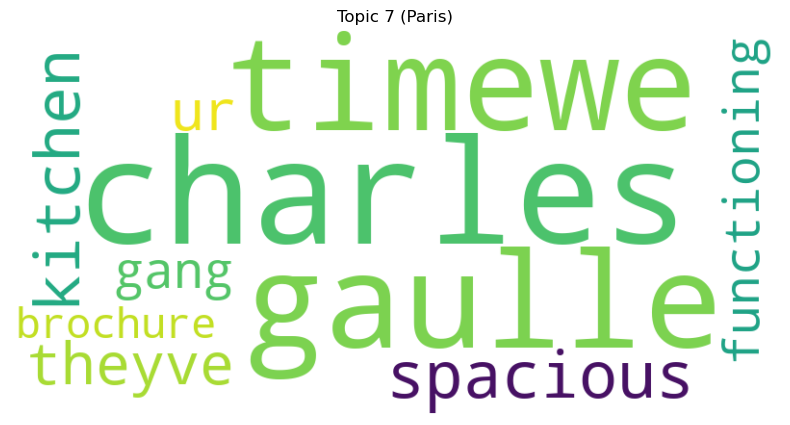

In [118]:
# Generate Word Clouds for Each Topic (you can adjust number of topics as needed)
lda_topic_words_cali = {}
lda_topic_words_hk = {}
lda_topic_words_paris = {}

for topic in range(7):  # Adjust the range to the number of topics
    words_cali = dict(lda_model_cali.show_topic(topic, 10))  # Top 10 words for each topic in California
    words_hk = dict(lda_model_hk.show_topic(topic, 10))  # Top 10 words for each topic in Hong Kong
    words_paris = dict(lda_model_paris.show_topic(topic, 10))  # Top 10 words for each topic in Paris
    
    lda_topic_words_cali[f"Topic {topic+1}"] = list(words_cali.keys())
    lda_topic_words_hk[f"Topic {topic+1}"] = list(words_hk.keys())
    lda_topic_words_paris[f"Topic {topic+1}"] = list(words_paris.keys())
    
    # Generate Word Cloud for each topic in California
    wordcloud_cali = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_cali)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_cali, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic+1} (California)")
    plt.show()

    # Generate Word Cloud for each topic in Hong Kong
    wordcloud_hk = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_hk)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_hk, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic+1} (Hong Kong)")
    plt.show()

    # Generate Word Cloud for each topic in Paris
    wordcloud_paris = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_paris)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_paris, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic+1} (Paris)")
    plt.show()


In [119]:
# Print the top words for each topic (for example, the top 10 words)
num_words = 10

# Print topics for each branch
topics_cali = lda_model_cali.print_topics(num_words=num_words)
topics_hk = lda_model_hk.print_topics(num_words=num_words)
topics_paris = lda_model_paris.print_topics(num_words=num_words)

print("Topics for California:")
for topic in topics_cali:
    print(f"Topic {topic[0]}: {topic[1]}")

print("\nTopics for Hong Kong:")
for topic in topics_hk:
    print(f"Topic {topic[0]}: {topic[1]}")

print("\nTopics for Paris:")
for topic in topics_paris:
    print(f"Topic {topic[0]}: {topic[1]}")

Topics for California:
Topic 0: 0.062*"mountain" + 0.044*"ride" + 0.036*"space" + 0.028*"pirate" + 0.027*"jones" + 0.026*"indiana" + 0.021*"haunted" + 0.021*"star" + 0.020*"tour" + 0.019*"splash"
Topic 1: 0.041*"disneyland" + 0.030*"disney" + 0.029*"park" + 0.020*"time" + 0.016*"year" + 0.014*"place" + 0.011*"visit" + 0.011*"world" + 0.010*"go" + 0.010*"much"
Topic 2: 0.032*"ride" + 0.025*"line" + 0.023*"get" + 0.021*"time" + 0.019*"park" + 0.018*"day" + 0.014*"wait" + 0.013*"pas" + 0.013*"fast" + 0.012*"people"
Topic 3: 0.032*"member" + 0.028*"cast" + 0.025*"u" + 0.014*"employee" + 0.014*"staff" + 0.013*"birthday" + 0.011*"told" + 0.010*"service" + 0.009*"guest" + 0.008*"asked"
Topic 4: 0.051*"hotel" + 0.019*"bus" + 0.014*"shuttle" + 0.012*"resort" + 0.011*"pool" + 0.009*"paradise" + 0.009*"pier" + 0.008*"room" + 0.008*"anaheim" + 0.007*"grand"
Topic 5: 0.030*"day" + 0.018*"ride" + 0.017*"food" + 0.016*"great" + 0.015*"show" + 0.015*"park" + 0.013*"kid" + 0.012*"parade" + 0.011*"good"

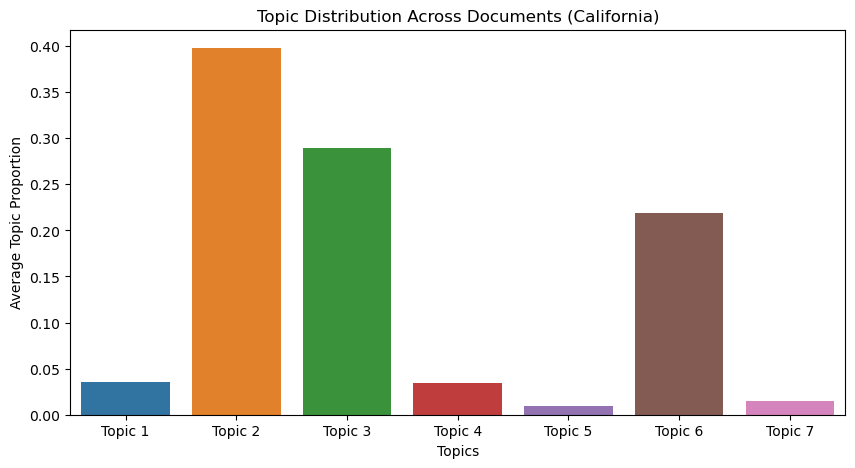

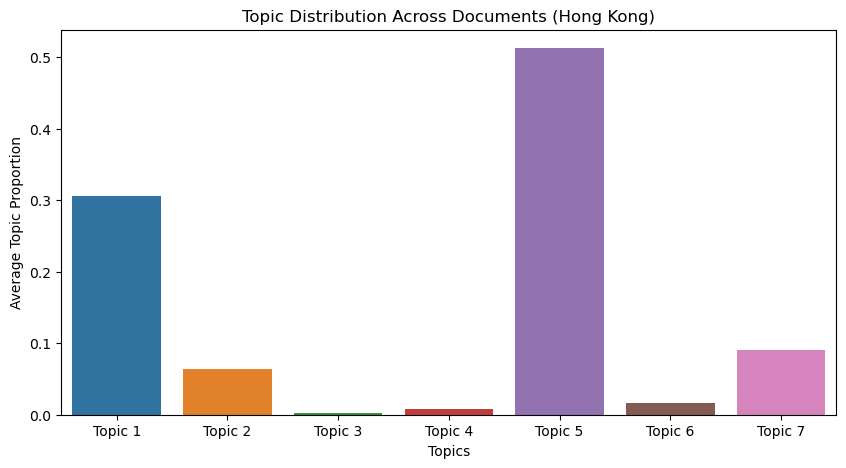

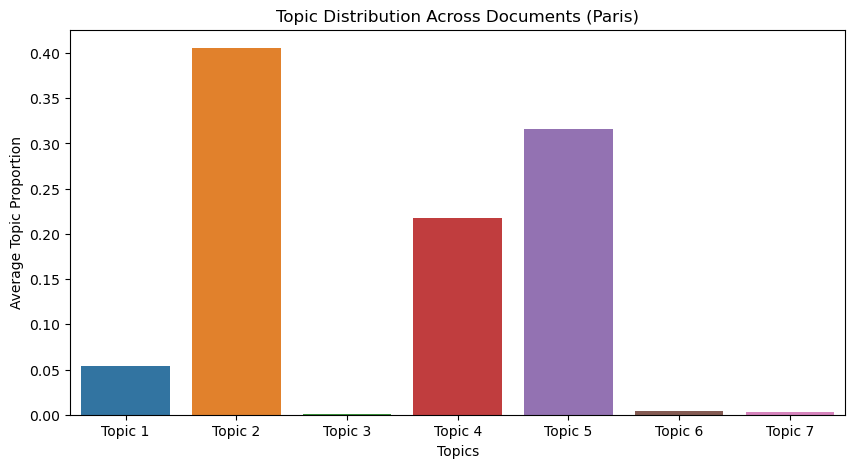

In [120]:
# Visualize Topic Distribution
def plot_topic_distributions(lda_model, corpus, branch_name):
    topic_proportions = np.array([lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus])
    topic_proportions = np.array([[prob for _, prob in doc] for doc in topic_proportions])
    avg_topic_proportions = topic_proportions.mean(axis=0)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=[f'Topic {i+1}' for i in range(len(avg_topic_proportions))], y=avg_topic_proportions)
    plt.xlabel("Topics")
    plt.ylabel("Average Topic Proportion")
    plt.title(f"Topic Distribution Across Documents ({branch_name})")
    plt.show()
    
# Plot topic distribution for each branch
plot_topic_distributions(lda_model_cali, corpus_cali, "California")
plot_topic_distributions(lda_model_hk, corpus_hk, "Hong Kong")
plot_topic_distributions(lda_model_paris, corpus_paris, "Paris")

In [121]:
# Function to get topic distribution for each document
def get_topic_distribution(lda_model, corpus):
    topic_distributions = []
    for doc in corpus:
        topic_dist = lda_model.get_document_topics(doc, minimum_probability=0)
        topic_dist_dict = dict(topic_dist)
        for i in range(lda_model.num_topics):
            if i not in topic_dist_dict:
                topic_dist_dict[i] = 0
        topic_distributions.append(topic_dist_dict)

    # Create a DataFrame
    df_topic_distributions = pd.DataFrame(topic_distributions)
    df_topic_distributions = df_topic_distributions.reindex(sorted(df_topic_distributions.columns), axis=1)
    return df_topic_distributions

# Example usage (assuming lda_model and corpus are already defined for each branch):
topic_distribution_cali = get_topic_distribution(lda_model_cali, corpus_cali)
topic_distribution_hk = get_topic_distribution(lda_model_hk, corpus_hk)
topic_distribution_paris = get_topic_distribution(lda_model_paris, corpus_paris)

topic_distribution_cali, topic_distribution_hk, topic_distribution_paris

(              0         1         2         3         4         5         6
 0      0.007592  0.723520  0.133506  0.008265  0.003173  0.119968  0.003976
 1      0.005730  0.192322  0.287689  0.006426  0.002372  0.502492  0.002970
 2      0.006029  0.238468  0.576208  0.031686  0.002488  0.142007  0.003115
 3      0.130759  0.508841  0.292767  0.002900  0.001104  0.062244  0.001383
 4      0.010596  0.347716  0.222957  0.011469  0.004386  0.397382  0.005495
 ...         ...       ...       ...       ...       ...       ...       ...
 19401  0.002073  0.398930  0.361652  0.002415  0.000857  0.224609  0.009463
 19402  0.010145  0.237202  0.499476  0.010837  0.004207  0.132621  0.105511
 19403  0.002466  0.151977  0.646786  0.137653  0.001025  0.058809  0.001284
 19404  0.009696  0.552004  0.217521  0.010431  0.004043  0.201244  0.005062
 19405  0.149617  0.258758  0.371019  0.015439  0.014442  0.184508  0.006217
 
 [19406 rows x 7 columns],
              0         1         2         3  